In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd  # Example, if using tabular data
import numpy as np
import cv2 as cv
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import sys
import os
import import_ipynb
from tqdm import tqdm
import re
#import image_utils as iu
%run ./image_utils.ipynb
%run ./clustering.ipynb
BaseFolder = '../../datasets/'
positions = BaseFolder + 'positions/EGF/'
brightfields = BaseFolder + "brightfields/EGF/"

class DataLoader:
    def __init__(self, image_folder, csv_folder, clustering, fourier):
        self.image_folder = image_folder
        self.csv_folder = csv_folder
        self.clustering_transformer = clustering  
        self.fourier_transformer = fourier  
        
        # Get the sorted list of file names to ensure pairing
        # Get the sorted list of image files based on their position
        self.image_files = sorted(
            [f for f in os.listdir(self.image_folder) if f.endswith(('png', 'jpg', 'jpeg', 'tif', 'tiff'))],
            key=self.extract_position_brightfields
        )
        
        # Get the sorted list of CSV files based on their position
        self.csv_files = sorted(
            [f for f in os.listdir(self.csv_folder) if f.endswith('csv')],
            key=self.extract_position_positions
        )

        assert len(self.image_files) == len(self.csv_files), "The number of images and CSV files must be the same."
    
    def __fit__(self):
        processed_data = []
        
        for img_name, csv_name in tqdm(zip(self.image_files, self.csv_files), desc="Processing images and CSVs", total=len(self.image_files)):
            # Full paths to image and CSV
            img_path = os.path.join(self.image_folder, img_name)
            csv_path = os.path.join(self.csv_folder, csv_name)
            
            image= np.array(crop_png(img_path))
            X = trpos_conversion(csv_path)

            #Display the image and the positions
            display_plots(image,X)
             # Apply the clusering DBSCAN on the given position to create the initial mask
            clustered_positions = self.clustering_transformer.__set_dataset__(X).__fit__()
            mask, info_dict = clustered_positions.__create_mask__()
            
            # mask , independent_masks= self.__create_combined_mask__(info_dict)
            # get the brightfield image and add its 
            # Type specifies if the mask should keep or not the values inside the mask "keep"/"mask"
            
            processed_image = self.fourier_transformer.__set__(image,mask).__fit__(keep=True).plot_image_analysis()
            params = self.fourier_transformer.__get_image_params__()

            masked_region = params["Masked_Image"]

            print("Mask Shape", mask.shape, type(mask))
            print("Image shape", image.shape, type(image))
            # Compute histograms

            if mask.dtype != np.uint8:
                mask = mask.astype(np.uint8)
                
            hist_original = cv.calcHist([image], [0], mask, [256], [0, 256])
            hist_masked = cv.calcHist([masked_region], [0], None, [256], [0, 256])
            
            # Normalize histograms
            hist_original = cv.normalize(hist_original, hist_original).flatten()
            hist_masked = cv.normalize(hist_masked, hist_masked).flatten()
            
            # Compute correlation
            correlation = cv.compareHist(hist_original, hist_masked, cv.HISTCMP_CORREL)
            
            print(f"Correlation: {correlation}")
            
            # Plot histograms
            plt.figure()
            plt.title("Histogram Comparison")
            plt.xlabel("Pixel Value")
            plt.ylabel("Frequency")
            plt.plot(hist_original, color='r', label='Original Image')
            plt.plot(hist_masked, color='b', label='Masked Region')
            plt.legend()
            plt.show()
            # Store the processed results
            #processed_data.append((processed_image, clustered_positions))
        
        return self

    def extract_position_brightfields(self,filename):
        match = re.search(r'posXY(\d+)', filename)
        return int(match.group(1)) if match else float('inf') # Return a large number if 'position' not found to sort it last (though ideally, all files should have it)
    
    def extract_position_positions(self,filename):
        match = re.search(r'Steps_(\d+)', filename)
        return int(match.group(1)) if match else float('inf')

        
            

In [3]:
def split_image(image_np, num_rows, num_cols):
    # Get the height and width of the image
    img_height, img_width = image_np.shape
    
    # Calculate the size of each section
    section_height = img_height // num_rows
    section_width = img_width // num_cols
    
    # List to store the sections
    sections = []
    
    # Split the image into equal sections
    for row in range(num_rows):
        for col in range(num_cols):
            # Calculate the coordinates of the current section
            start_y = row * section_height
            start_x = col * section_width
            end_y = start_y + section_height
            end_x = start_x + section_width
            
            # Extract the section
            section = image_np[start_y:end_y, start_x:end_x]
            sections.append(section)
    
    return sections

# Example usage
image_np = np.random.rand(600, 800)  # Example: a random image with shape (600, 800)
num_rows, num_cols = 3, 4  # Split into 3x4 sections
sections = split_image(image_np, num_rows, num_cols)

# Output the shapes of the split sections
for idx, section in enumerate(sections):
    print(f"Section {idx + 1} shape: {section.shape}")


Section 1 shape: (200, 200)
Section 2 shape: (200, 200)
Section 3 shape: (200, 200)
Section 4 shape: (200, 200)
Section 5 shape: (200, 200)
Section 6 shape: (200, 200)
Section 7 shape: (200, 200)
Section 8 shape: (200, 200)
Section 9 shape: (200, 200)
Section 10 shape: (200, 200)
Section 11 shape: (200, 200)
Section 12 shape: (200, 200)


Processing images and CSVs:   0%|                                                                | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_285/430953026.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B = imageio.imread(Brightfield)


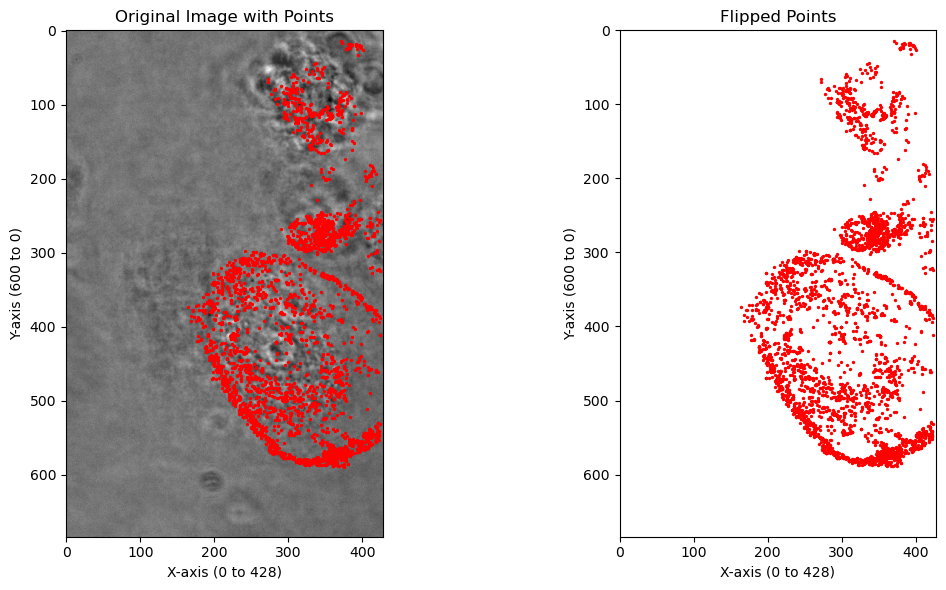

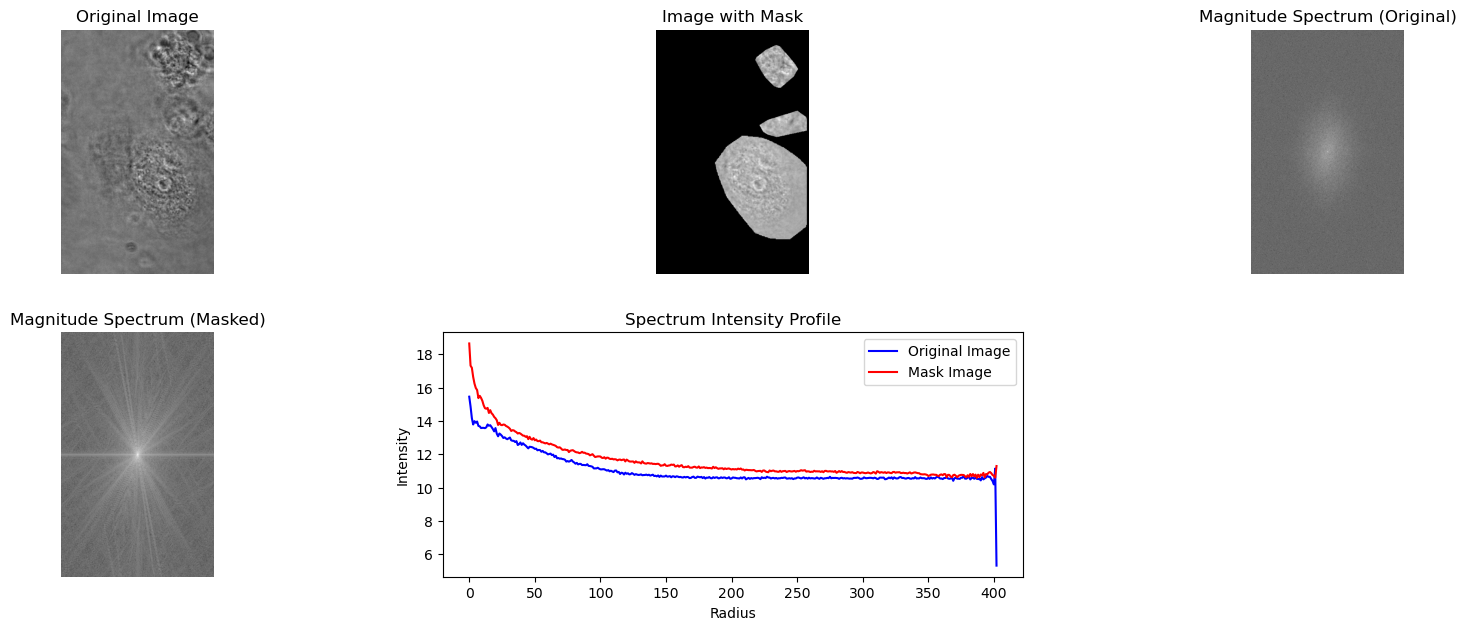

Mask Shape (684, 428) <class 'numpy.ndarray'>
Image shape (684, 428) <class 'numpy.ndarray'>
Correlation: 1.0


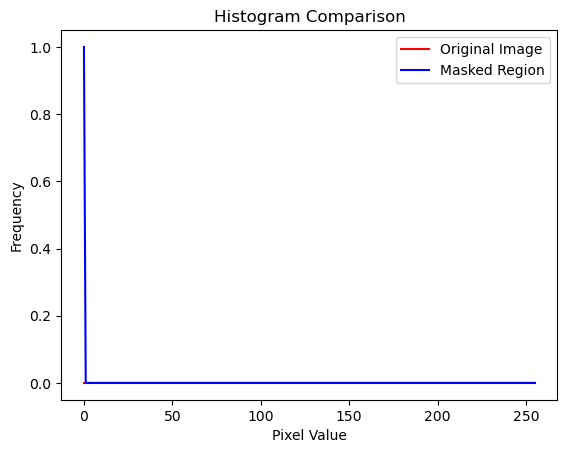

Processing images and CSVs:   9%|█████                                                   | 1/11 [00:01<00:17,  1.77s/it]/tmp/ipykernel_285/430953026.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B = imageio.imread(Brightfield)


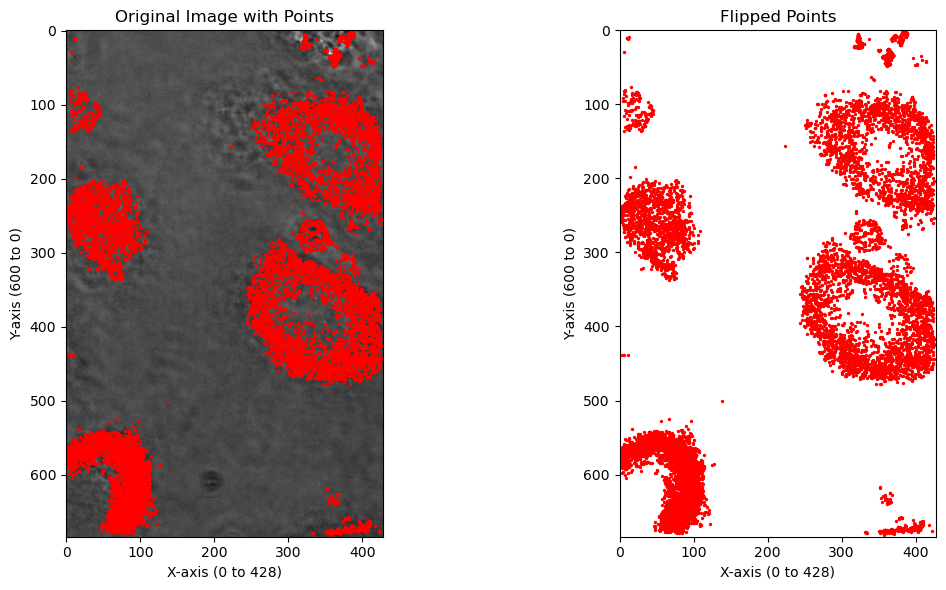

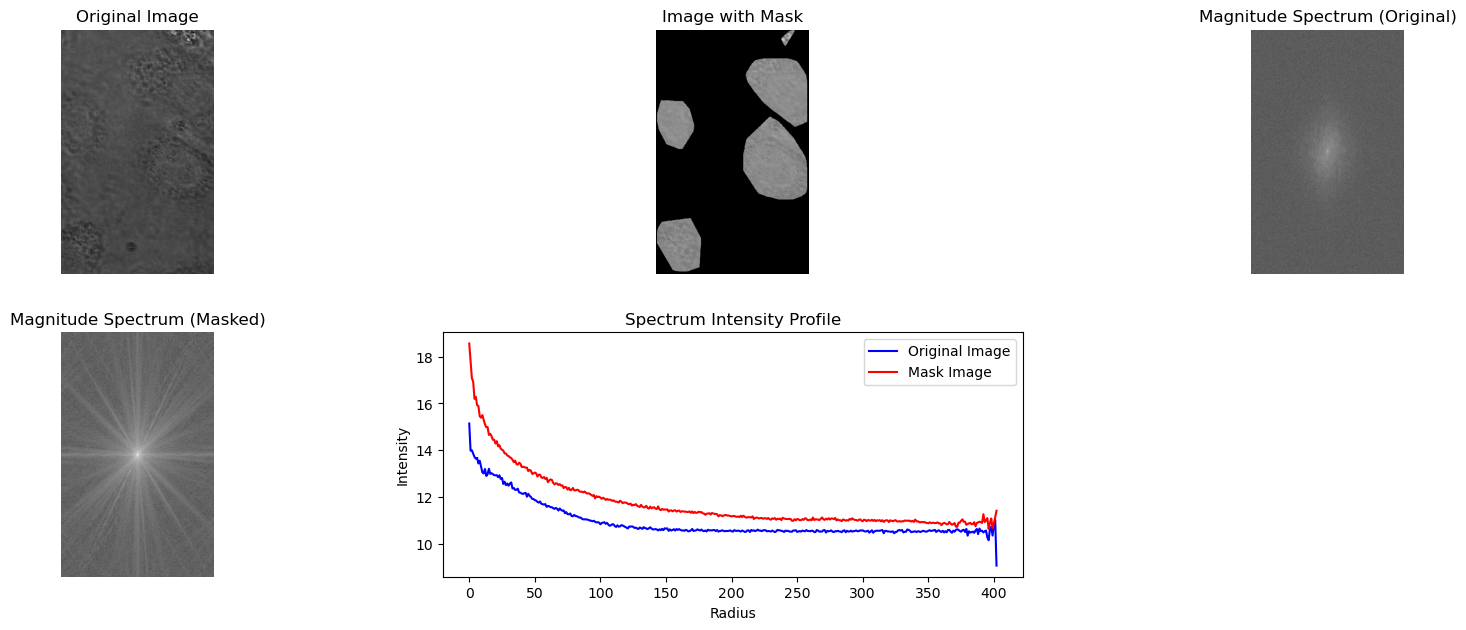

Mask Shape (684, 428) <class 'numpy.ndarray'>
Image shape (684, 428) <class 'numpy.ndarray'>
Correlation: 1.0


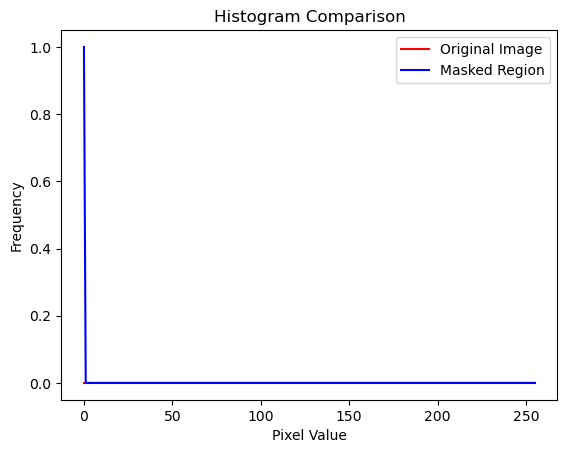

Processing images and CSVs:  18%|██████████▏                                             | 2/11 [00:06<00:33,  3.68s/it]/tmp/ipykernel_285/430953026.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B = imageio.imread(Brightfield)


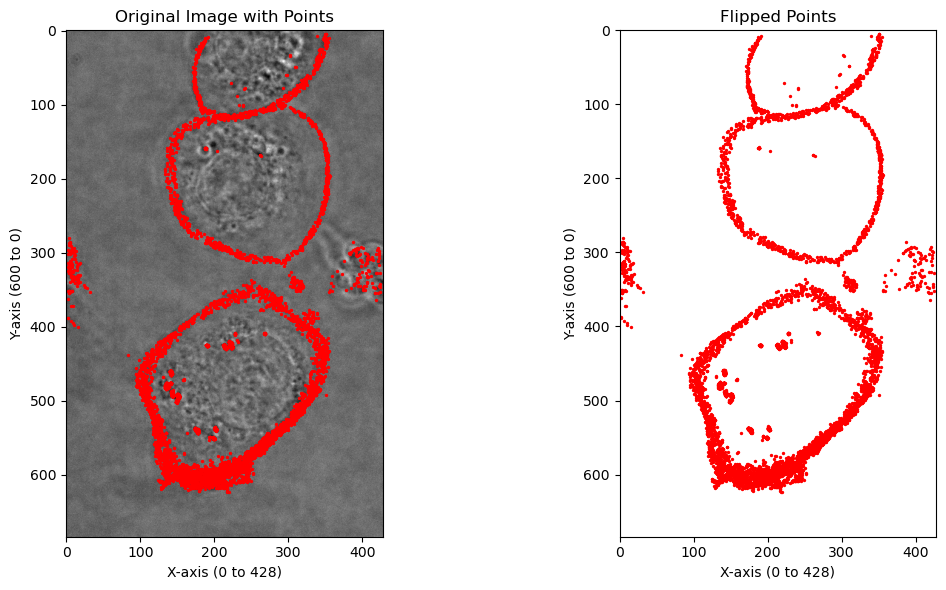

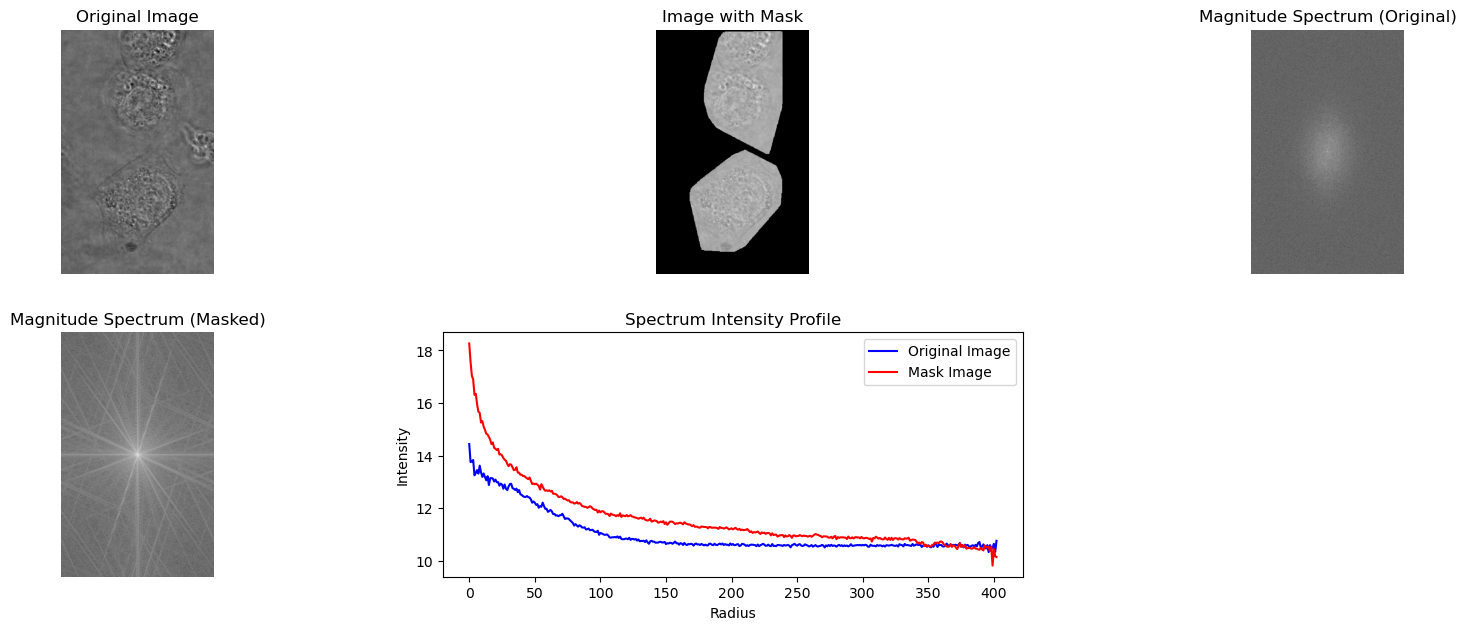

Mask Shape (684, 428) <class 'numpy.ndarray'>
Image shape (684, 428) <class 'numpy.ndarray'>
Correlation: 1.0


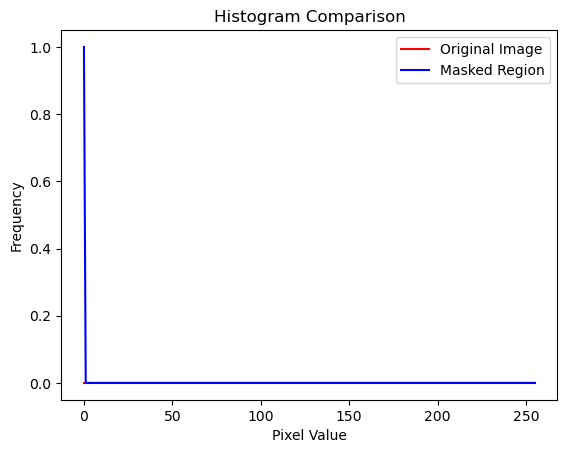

Processing images and CSVs:  27%|███████████████▎                                        | 3/11 [00:09<00:25,  3.16s/it]/tmp/ipykernel_285/430953026.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B = imageio.imread(Brightfield)


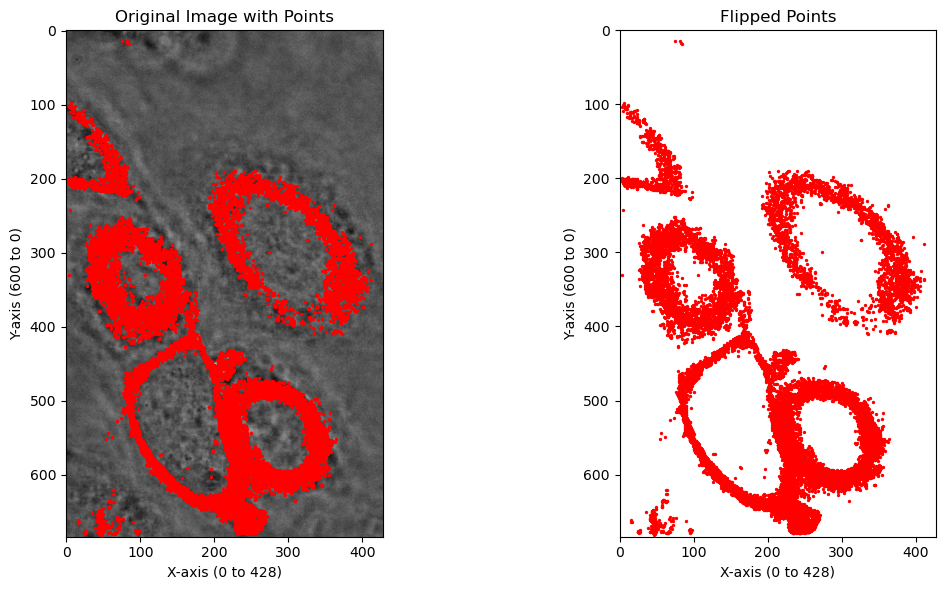

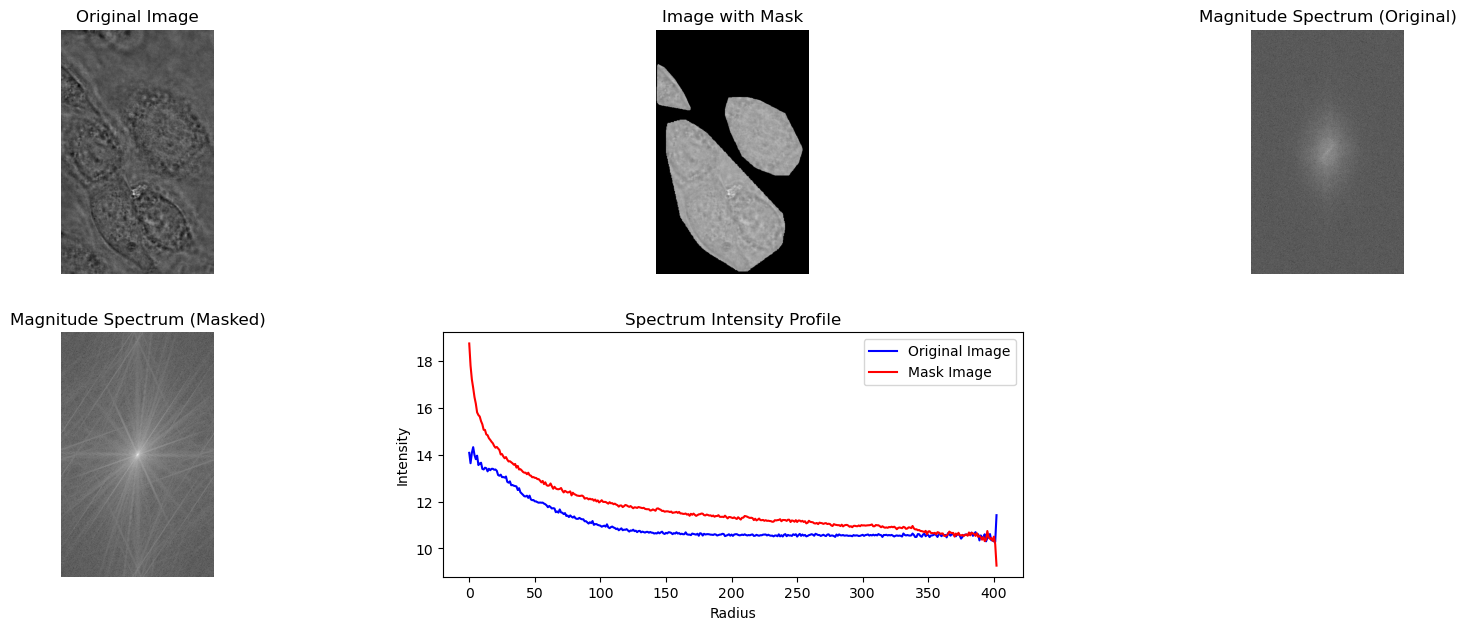

Mask Shape (684, 428) <class 'numpy.ndarray'>
Image shape (684, 428) <class 'numpy.ndarray'>
Correlation: 1.0


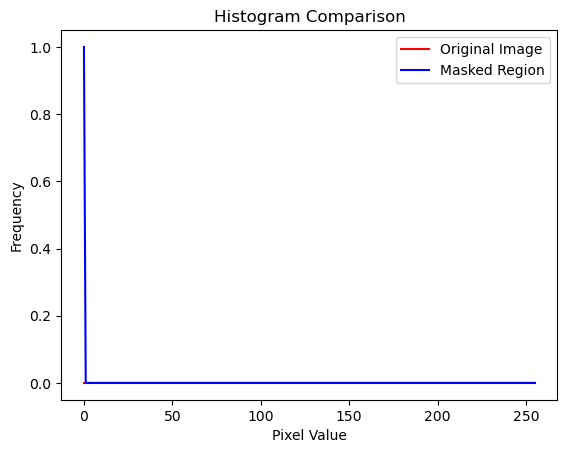

Processing images and CSVs:  36%|████████████████████▎                                   | 4/11 [00:23<00:53,  7.58s/it]/tmp/ipykernel_285/430953026.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B = imageio.imread(Brightfield)


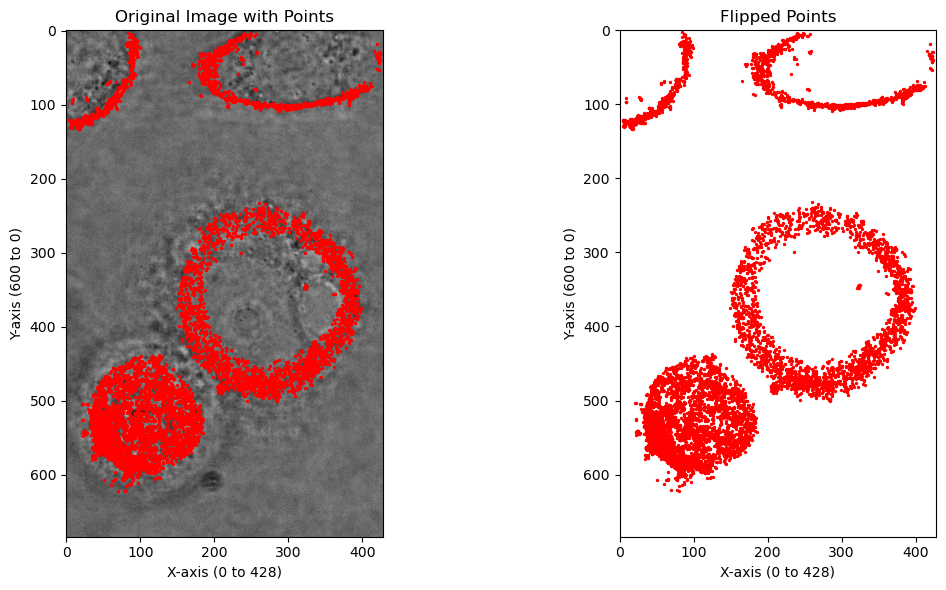

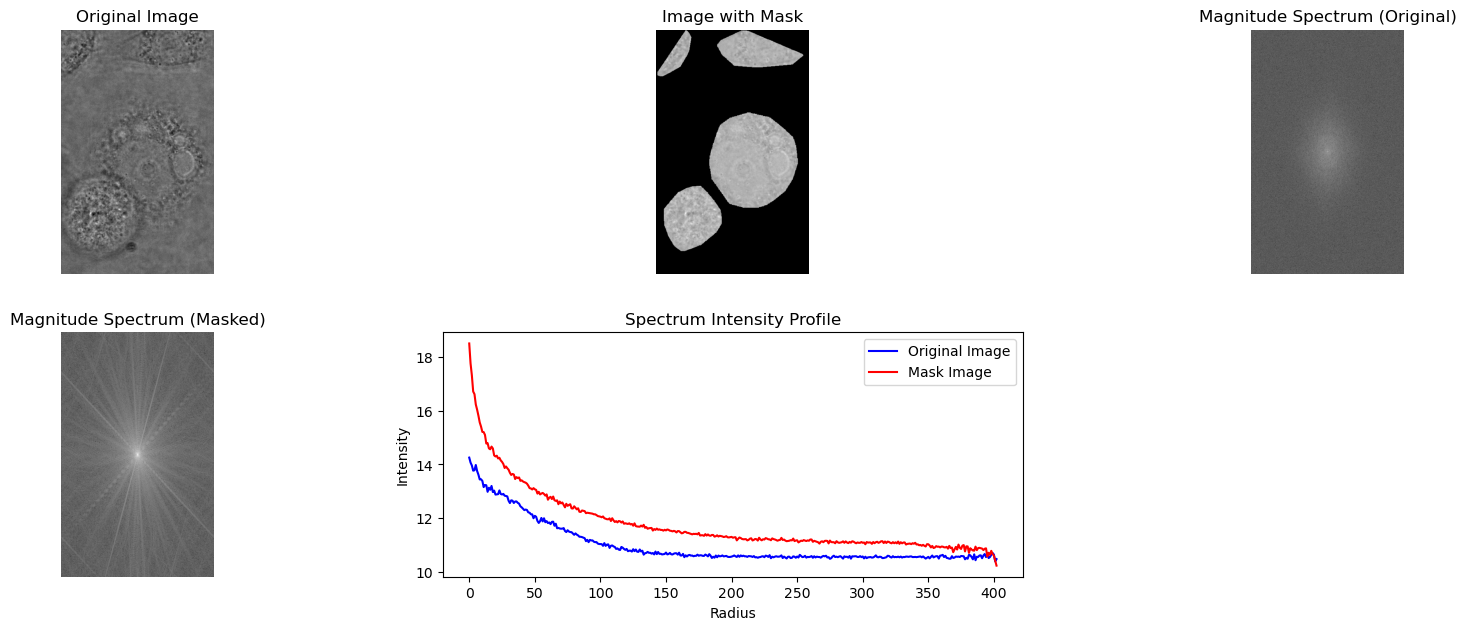

Mask Shape (684, 428) <class 'numpy.ndarray'>
Image shape (684, 428) <class 'numpy.ndarray'>
Correlation: 1.0


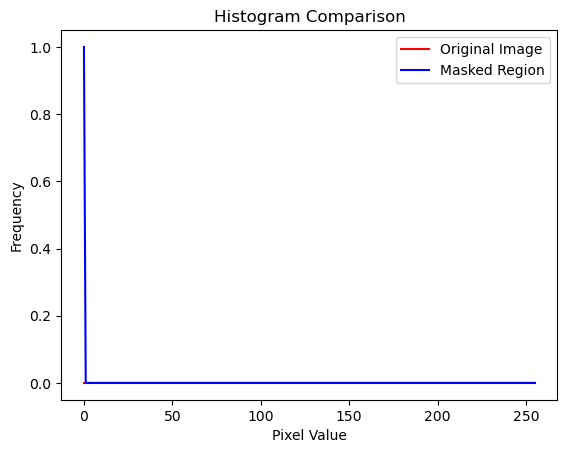

Processing images and CSVs:  45%|█████████████████████████▍                              | 5/11 [00:27<00:36,  6.15s/it]/tmp/ipykernel_285/430953026.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B = imageio.imread(Brightfield)


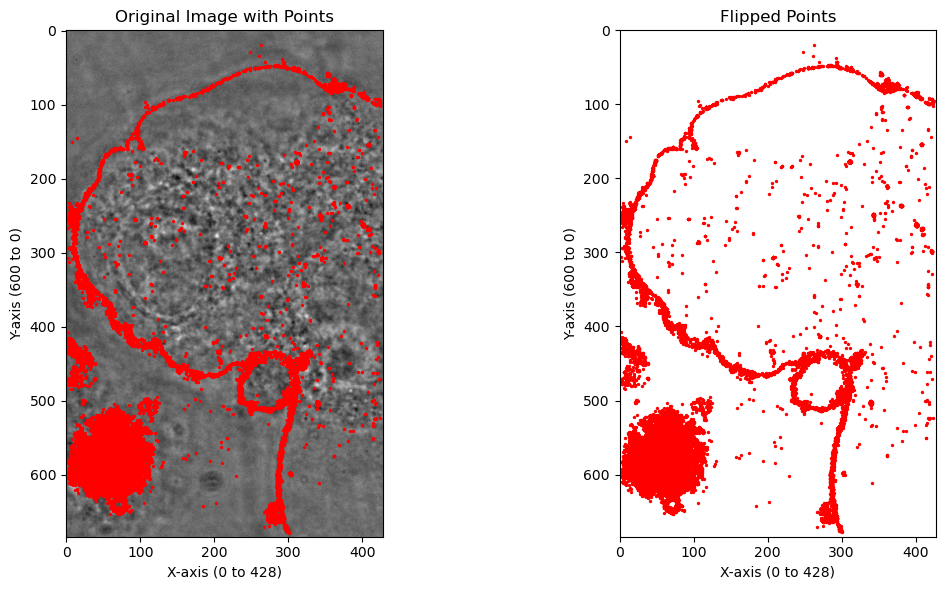

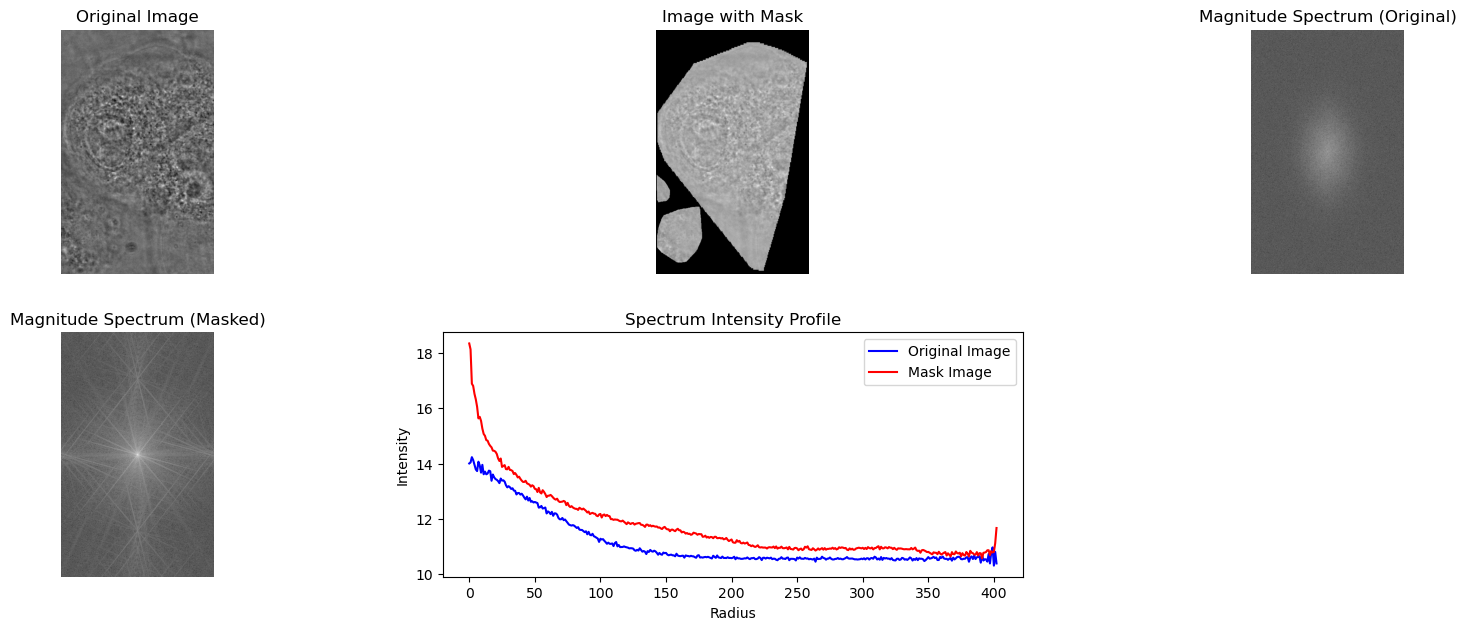

Mask Shape (684, 428) <class 'numpy.ndarray'>
Image shape (684, 428) <class 'numpy.ndarray'>
Correlation: 1.0


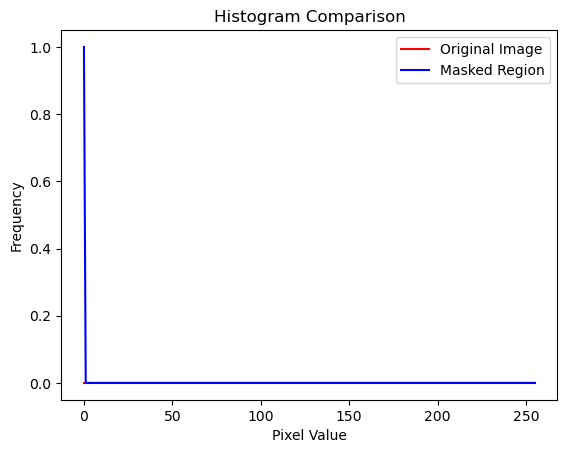

Processing images and CSVs:  55%|██████████████████████████████▌                         | 6/11 [00:35<00:34,  6.98s/it]/tmp/ipykernel_285/430953026.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B = imageio.imread(Brightfield)


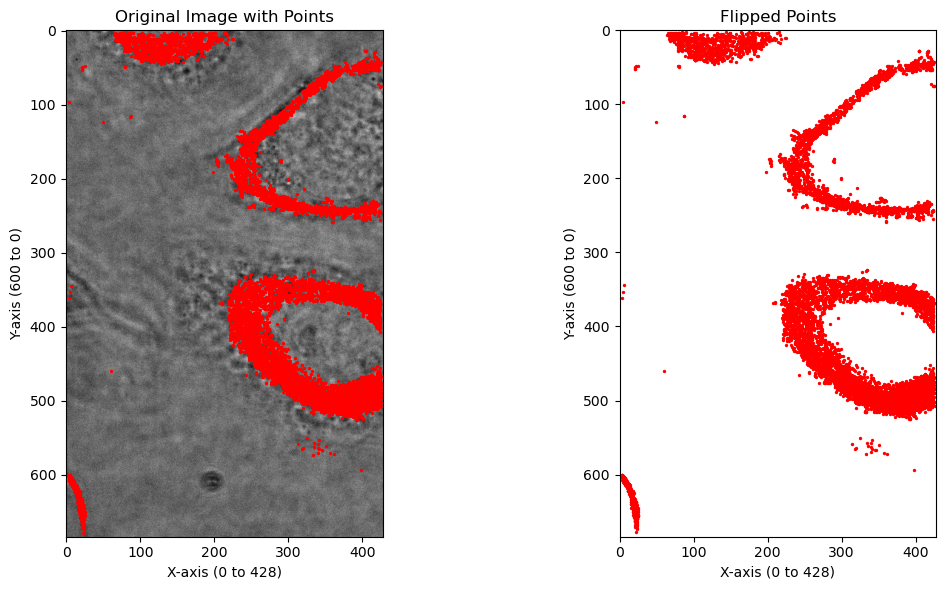

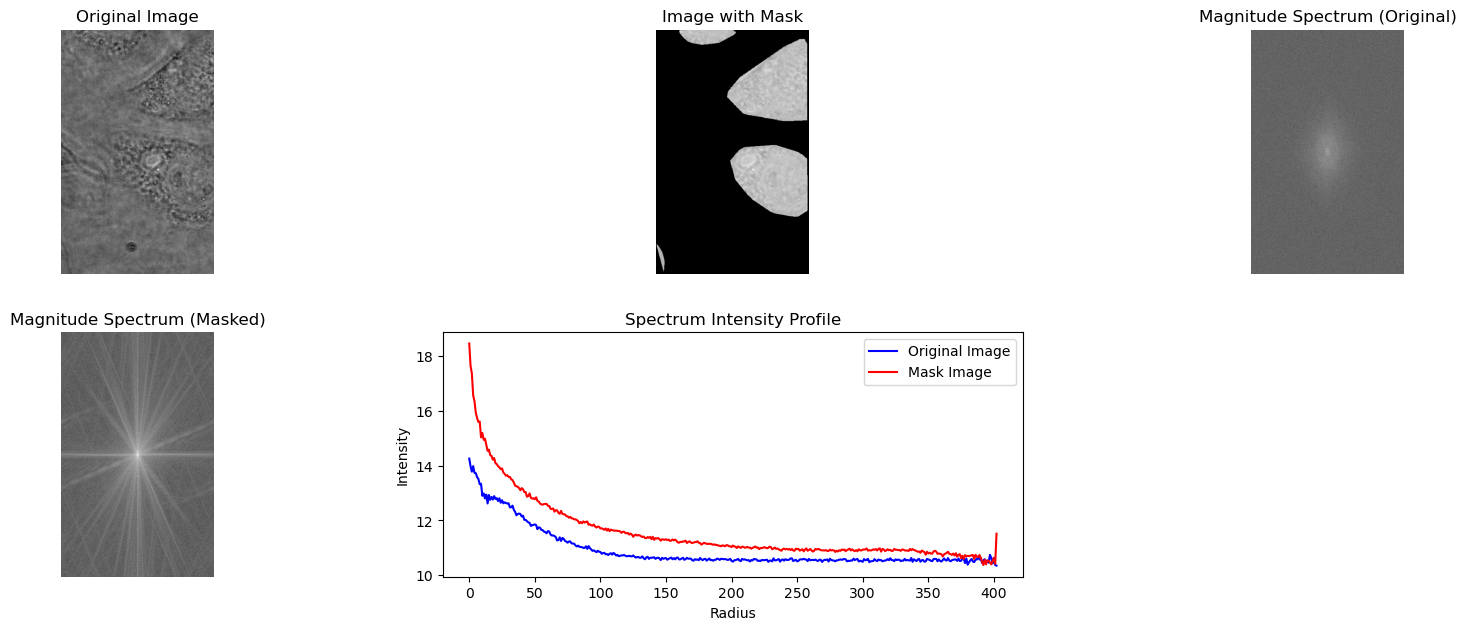

Mask Shape (684, 428) <class 'numpy.ndarray'>
Image shape (684, 428) <class 'numpy.ndarray'>
Correlation: 1.0


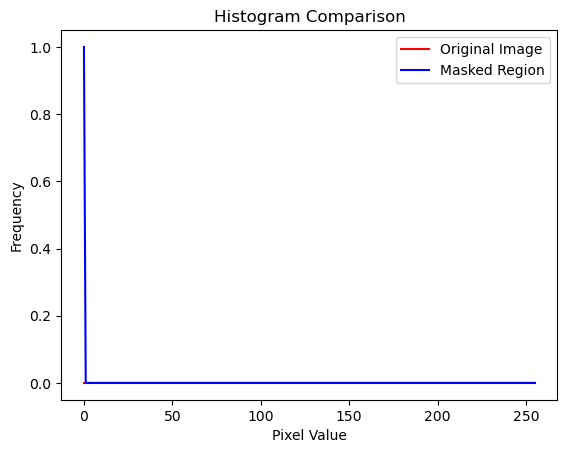

Processing images and CSVs:  64%|███████████████████████████████████▋                    | 7/11 [00:38<00:22,  5.59s/it]/tmp/ipykernel_285/430953026.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B = imageio.imread(Brightfield)


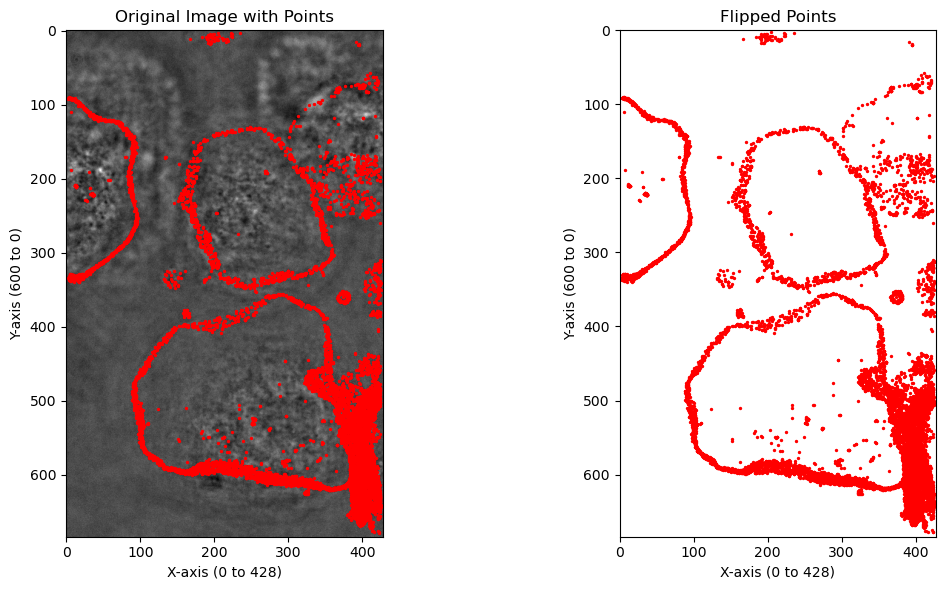

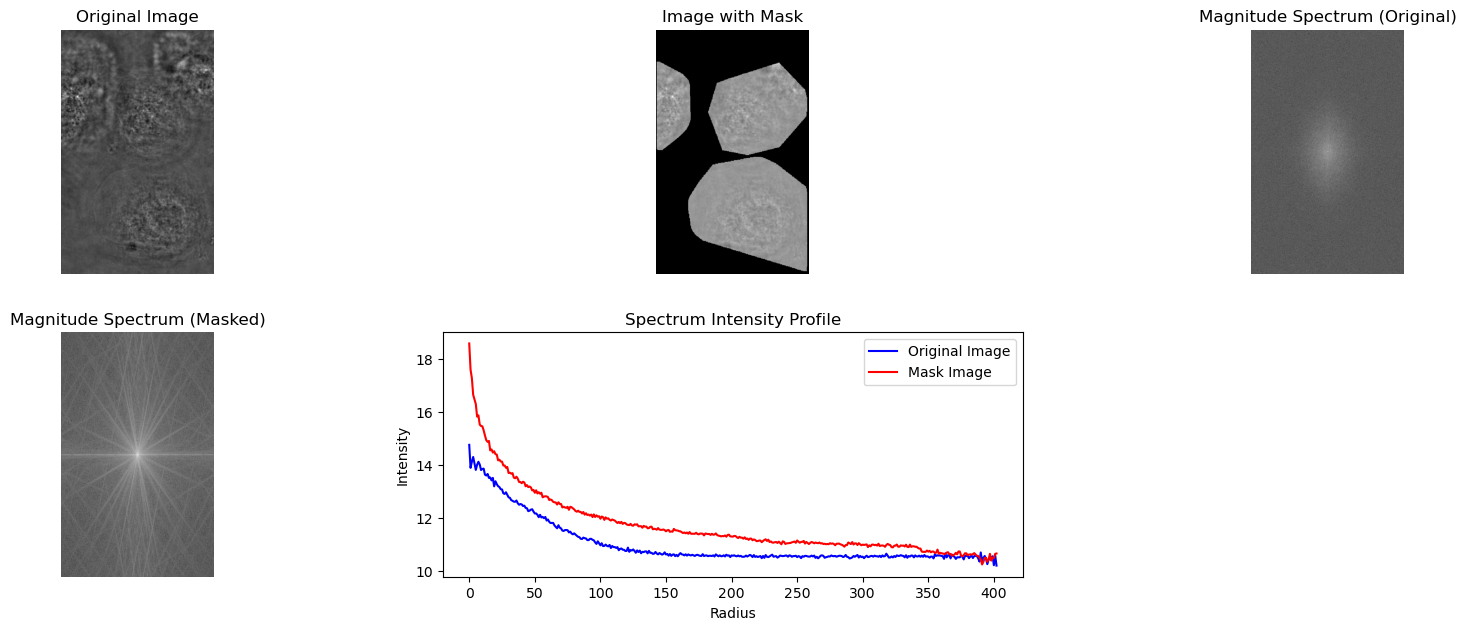

Mask Shape (684, 428) <class 'numpy.ndarray'>
Image shape (684, 428) <class 'numpy.ndarray'>
Correlation: 1.0


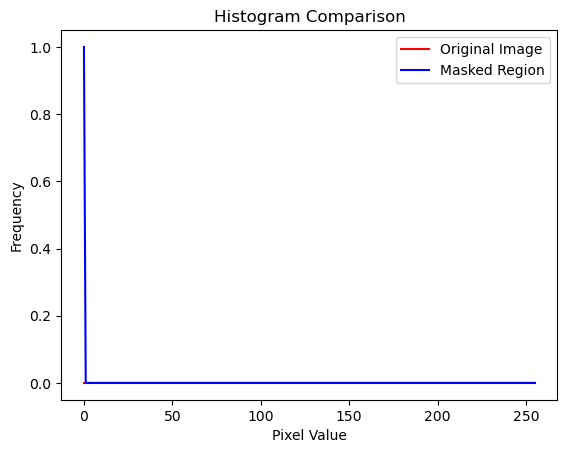

Processing images and CSVs:  73%|████████████████████████████████████████▋               | 8/11 [00:43<00:16,  5.50s/it]/tmp/ipykernel_285/430953026.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B = imageio.imread(Brightfield)


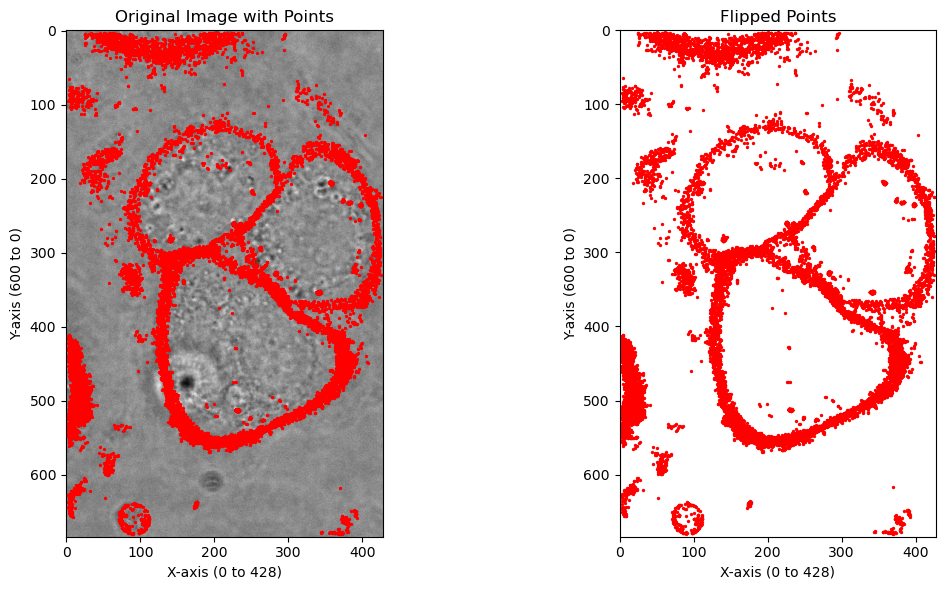

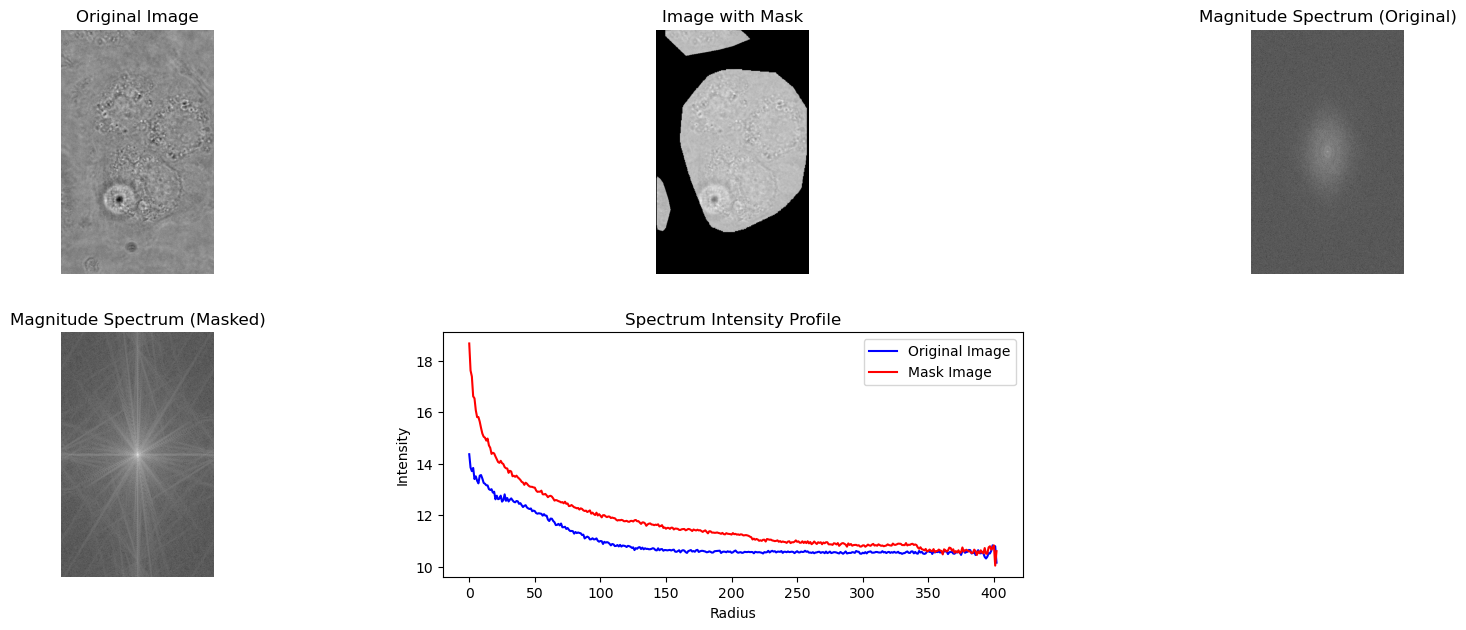

Mask Shape (684, 428) <class 'numpy.ndarray'>
Image shape (684, 428) <class 'numpy.ndarray'>
Correlation: 1.0


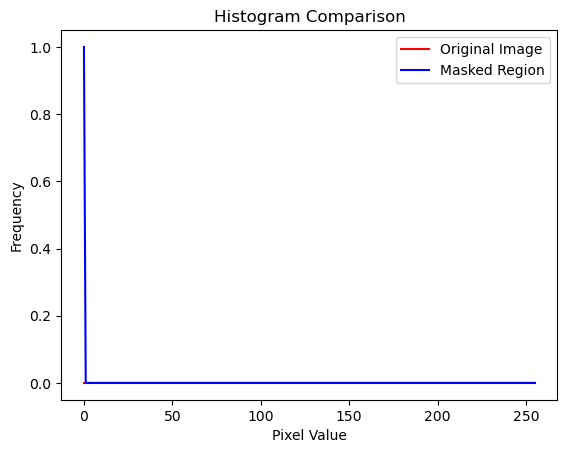

Processing images and CSVs:  82%|█████████████████████████████████████████████▊          | 9/11 [00:51<00:12,  6.09s/it]/tmp/ipykernel_285/430953026.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B = imageio.imread(Brightfield)


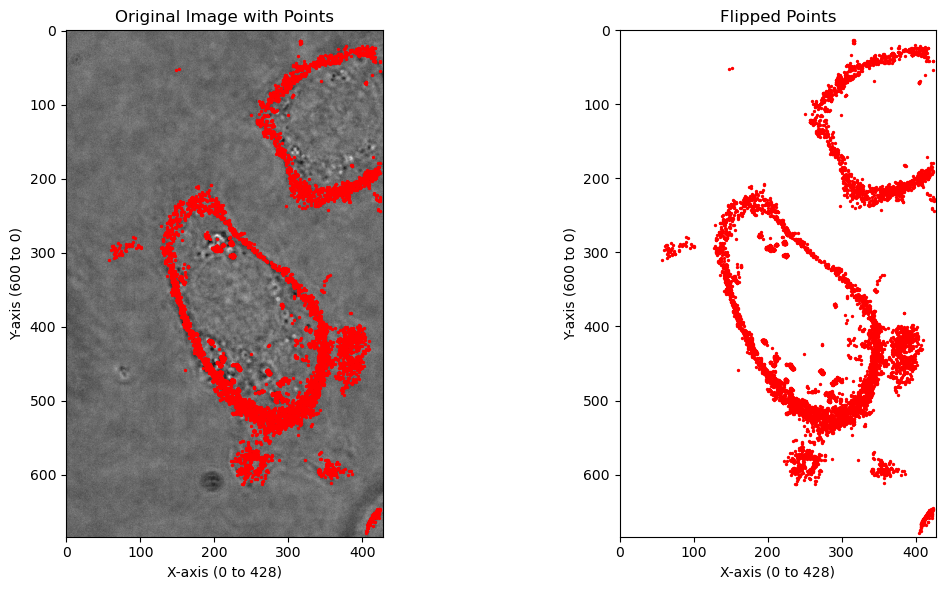

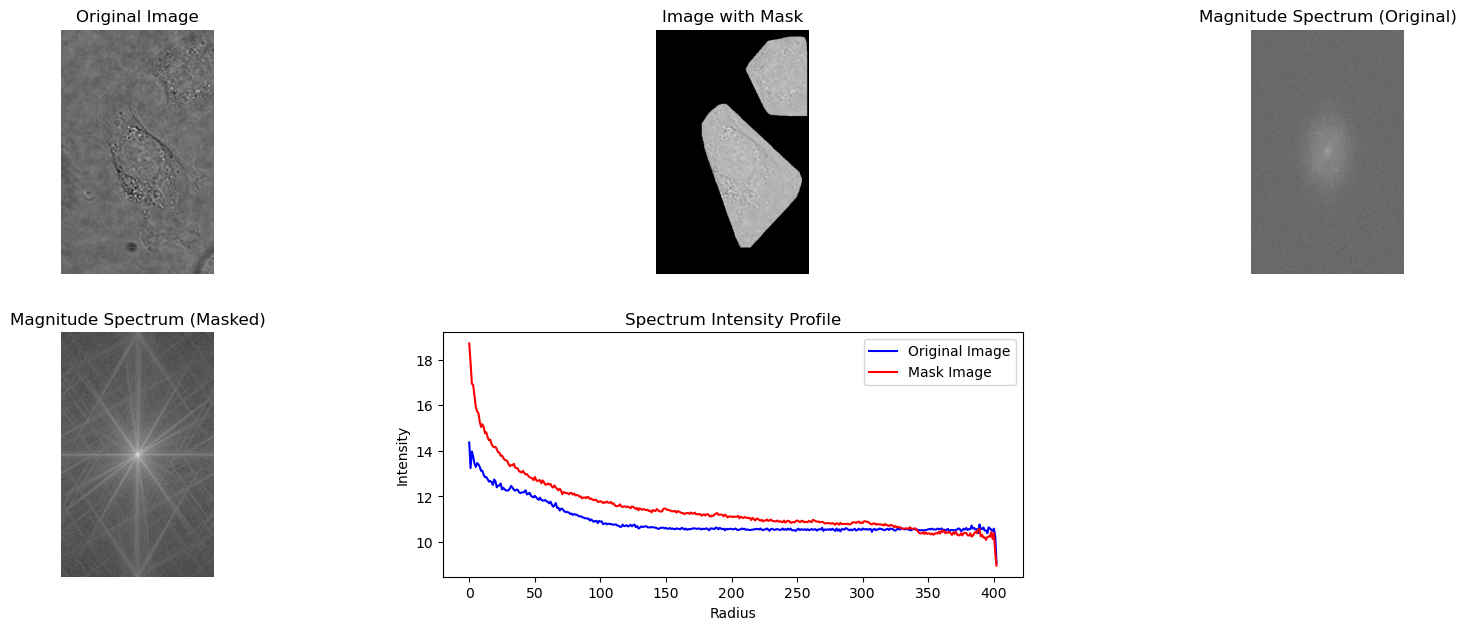

Mask Shape (684, 428) <class 'numpy.ndarray'>
Image shape (684, 428) <class 'numpy.ndarray'>
Correlation: 1.0


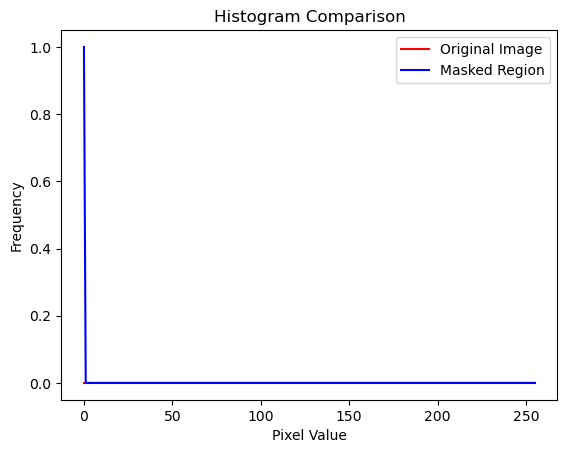

Processing images and CSVs:  91%|██████████████████████████████████████████████████     | 10/11 [00:54<00:05,  5.08s/it]/tmp/ipykernel_285/430953026.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B = imageio.imread(Brightfield)


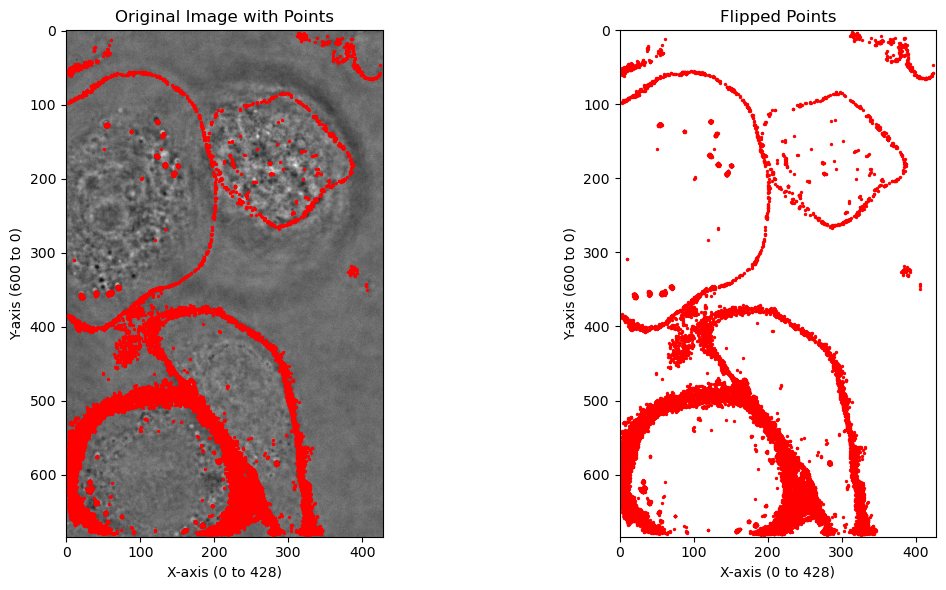

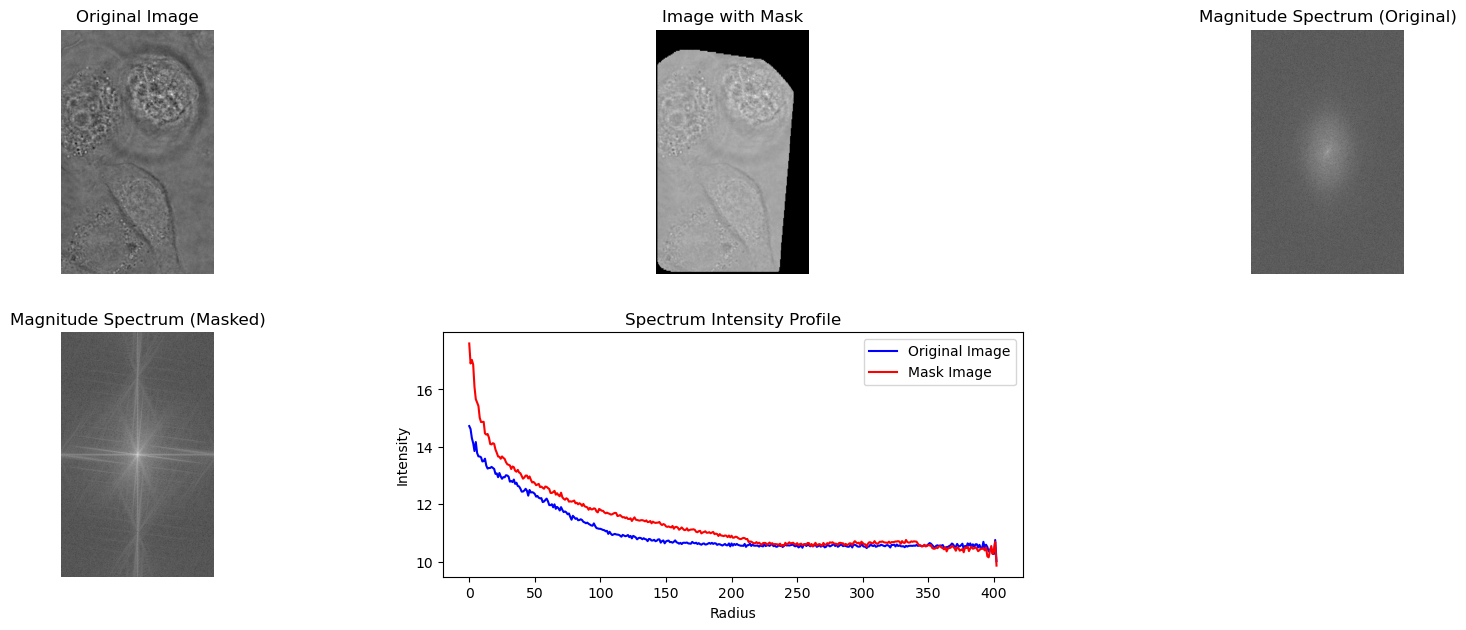

Mask Shape (684, 428) <class 'numpy.ndarray'>
Image shape (684, 428) <class 'numpy.ndarray'>
Correlation: 1.0


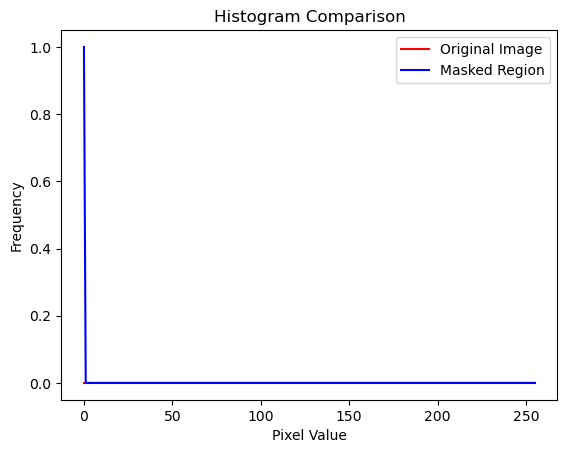

Processing images and CSVs: 100%|███████████████████████████████████████████████████████| 11/11 [01:18<00:00,  7.11s/it]


In [4]:
# Initialize objects of type A and B
Clustering_Transformer = ClusteringAlgorithm()
Fourier_Transformer = FourierTransformer()

# Instantiate DataLoader
data_loader = DataLoader(brightfields, positions, Clustering_Transformer, Fourier_Transformer)

# Fit the data loader
processed_data = data_loader.__fit__()
